---
title: DiffEdit implementation using 🤗 Hugging Face
author: Aayush Agrawal
date: "1999-11-17"
categories: [Stable Diffusion]
image: "./diverging_roads.png"
format:
    html:
        code-fold: false
        number-sections: true
---

> An implementation of [DIFFEDIT: DIFFUSION-BASED SEMANTIC IMAGE EDITING WITH MASK GUIDANCE](https://arxiv.org/pdf/2210.11427.pdf)  using  🤗 [hugging face diffusers library](https://github.com/huggingface/diffusers).

In this post, I am going to implement a recent paper which came from researchers in Meta AI and Sorbonne Universite named **`DIFFEDIT`**. This blog will make more sense to people who are either familiar with stable diffusion process or are reading after four part series I made on Stable Diffusion - <br>
1. **Part 1** - [Stable diffusion using 🤗 Hugging Face - Introduction](https://aayushmnit.com/posts/2022-11-02-StabeDiffusionP1/2022-11-02-StableDiffusionP1.html). <br>
2. **Part 2** - [Stable diffusion using 🤗 Hugging Face - Looking under the hood](https://aayushmnit.com/posts/2022-11-05-StableDiffusionP2/2022-11-05-StableDiffusionP2.html). <br>
3. **Part 3** - [Stable diffusion using 🤗 Hugging Face - Putting everything together](https://aayushmnit.com/posts/2022-11-07-StableDiffusionP3/2022-11-07-StableDiffusionP3.html) <br>
4. **Part 4** - [Stable diffusion using 🤗 Hugging Face - Variations of Stable Diffusion](https://aayushmnit.com/posts/2022-11-10-StableDiffusionP4/2022-11-10-StableDiffusionP4.html)

Originally, this was the blog post I wanted to write about, but realized there is no single place for understanding Stable diffusion with code. Which is the reason I ended up creating the four part series as reference or pre-read material to understand this paper.

## What is DiffEdit?

In simple terms, you can think of `DiffEdit` approach as a more controlled version of `Image to Image` pipeline. `DiffEdit` takes three inputs- <br> 
1. An input image <br>
2. `Caption` - Describing the input image <br>
3. `Target Query` - Describing the new image you want to generate<br>

and produces a modified version of the original image based on the query text. This process is particularly good if you want to make a slight tweak to the actual image without completely modifying it.

<figure align = "center">
    <img src="./diffedit_hl.png" style="width:100%">
<figcaption align = "center">
        Fig. 1: Overview of Diff Edit.
</figcaption>
</figure>

As we can see from the image above only the fruits parts of the image was replaced with pears. Pretty amazing results!

The way authors explains they achieve it by introducing a mask generation module which determines which part of the image should be edited and then only perform text based diffusion conditioning on the masked part.

<figure align = "center">
    <img src="./diffedit_intro.png" style="width:100%">
<figcaption align = "center">
        Fig. 2: From the paper DiffEdit[https://arxiv.org/pdf/2210.11427.pdf]. An approach to change an input image by providing caption text and new text.
</figcaption>
</figure>

As we can see from the image above taken from the paper, the authors create a mask from the input image which accurately determines the part of the image where fruits are present and generate a mask (shown in Orange) and then perform masked diffusion to replace fruits with pears. Reading further the authors provide a good visual representation of the whole `DiffEdit` process.

<figure align = "center">
    <img src="./diffedit_fullprocess.png" style="width:100%">
<figcaption align = "center">
        Fig. 3: Three steps of DiffEdit. Credit - [Paper](https://arxiv.org/pdf/2210.11427.pdf)
</figcaption>
</figure>

As I was reading this paper, it seems generating the masking is the most important step and rest is just textual conditioning using diffusion process. The conditioning of an image using mask is a similar idea implemented in [Hugging face In-Paint Pipeline](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_inpaint.py). As suggested by the authors, "there are three steps to `DiffEdit` process -  <br>
**Step 1:** Add noise to the input image, and denoise it:
once conditioned on the query text, and once conditioned on a reference text (or unconditionally). We derive a mask based on the difference in the denoising results. <br>
**Step2:** we encode the input
image with DDIM, to estimate the latents corresponding to the input image <br>
**Step3:** we perform DDIM decoding conditioned on the text query, using the inferred mask to replace the background with pixel values coming from the encoding process at the corresponding timestep"[^1]

In next sections we will start implementing these ideas into actual code.

Let's start by importing the required libraries and helper functions. All of this was already used and explained in the previous [part 2](https://aayushmnit.com/posts/2022-11-05-StableDiffusionP2/2022-11-05-StableDiffusionP2.html) and [part 3](https://aayushmnit.com/posts/2022-11-07-StableDiffusionP3/2022-11-07-StableDiffusionP3.html) of the stable diffusion series.

In [7]:
#| code-fold: true
import torch, logging

## disable warnings
logging.disable(logging.WARNING)  

## Imaging  library
from PIL import Image
from torchvision import transforms as tfms


## Basic libraries
from fastdownload import FastDownload
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import shutil
import os

## For video display
from IPython.display import HTML
from base64 import b64encode


## Import the CLIP artifacts 
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler

## Helper functions

def load_artifacts():
    '''
    A function to load all diffusion artifacts
    '''
    vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")
    unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
    text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")
    scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)    
    return vae, unet, tokenizer, text_encoder, scheduler

def load_image(p):
    '''
    Function to load images from a defined path
    '''
    return Image.open(p).convert('RGB').resize((512,512))

def pil_to_latents(image):
    '''
    Function to convert image to latents
    '''
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16) 
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

def latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def text_enc(prompts, maxlen=None):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt") 
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

vae, unet, tokenizer, text_encoder, scheduler = load_artifacts()

Let's also download an image which we will use for the code implementation process. 

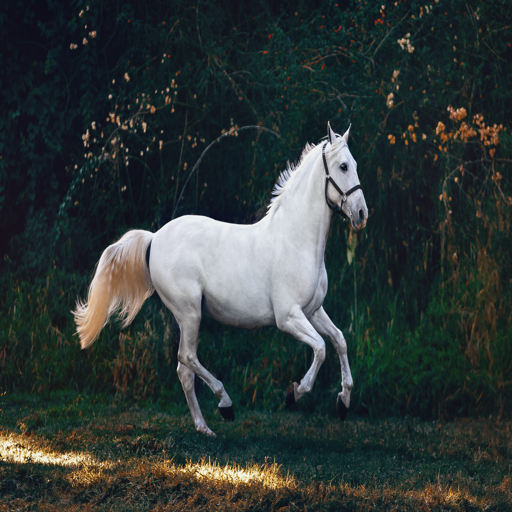

In [8]:
p = FastDownload().download('https://images.pexels.com/photos/1996333/pexels-photo-1996333.jpeg?cs=srgb&dl=pexels-helena-lopes-1996333.jpg&fm=jpg&_gl=1*1pc0nw8*_ga*OTk4MTI0MzE4LjE2NjY1NDQwMjE.*_ga_8JE65Q40S6*MTY2Njc1MjIwMC4yLjEuMTY2Njc1MjIwMS4wLjAuMA..')
init_img = load_image(p)
init_img

## Mask Creation: First Step of DiffEdit process

<figure align = "center">
    <img src="./step1.png" style="width:100%">
<figcaption align = "center">
        Fig. 4: Step 1 of the `DiffEdit` paper.
</figcaption>
</figure>

There is the more detailed explaination of Step 1 from the paper, here are the key parts mentioned - <br>
1. Denoise image using different text conditioning, one using reference text and other using query text and take differences from the result. The idea is there is more changes in the differed part and not in the background of the image. <br>
2. Repeat this differencing process 10 times and binarize the output by setting a 0.5 default to get the resultant mask. <br>

### Mask Creation: Purist implementation

First, we will try to implement the paper exactly how it's mentioned. We will modify the [prompt_2_img_i2i](https://aayushmnit.com/posts/2022-11-10-StableDiffusionP4/2022-11-10-StableDiffusionP4.html#variation-2-image-to-image-pipeline) function for this task.

In [12]:
def prompt_2_img_i2i(prompts, init_img, neg_prompts=None, g=7.5, seed=100, strength =0.8, steps=50, dim=512, save_int=False):
    """
    Diffusion process to convert prompt to image
    """
    # Converting textual prompts to embedding
    text = text_enc(prompts) 
    
    # Adding an unconditional prompt , helps in the generation process
    if not neg_prompts: uncond =  text_enc([""], text.shape[1])
    else: uncond =  text_enc(neg_prompt, text.shape[1])
    emb = torch.cat([uncond, text])
    
    # Setting the seed
    if seed: torch.manual_seed(seed)
    
    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)
    
    # Convert the seed image to latent
    init_latents = pil_to_latents(init_img)
    
    # Figuring initial time step based on strength
    init_timestep = int(steps * strength) 
    timesteps = scheduler.timesteps[-init_timestep]
    timesteps = torch.tensor([timesteps], device="cuda")
    
    # Adding noise to the latents 
    noise = torch.randn(init_latents.shape, generator=None, device="cuda", dtype=init_latents.dtype)
    init_latents = scheduler.add_noise(init_latents, noise, timesteps)
    latents = init_latents
    
    # Computing the timestep to start the diffusion loop
    t_start = max(steps - init_timestep, 0)
    timesteps = scheduler.timesteps[t_start:].to("cuda")
    
    # Iterating through defined steps
    for i,ts in enumerate(tqdm(timesteps)):
        # We need to scale the i/p latents to match the variance
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        
        # Predicting noise residual using U-Net
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
            
        # Performing Guidance
        pred = u + g*(t-u)
        
        # Conditioning  the latents
        latents = scheduler.step(pred, ts, latents).prev_sample
        
        # Saving intermediate images
        if save_int: 
            if not os.path.exists(f'./steps'):
                os.mkdir(f'./steps')
            latents_to_pil(latents)[0].save(f'steps/{i:04}.jpeg')
            
    # Returning the latent representation to output an image of 3x512x512
    return latents_to_pil(latents)

In [57]:
diff = {}
for idx in range(10):
    orig_noise = prompt_2_img_i2i(prompts=["a horse image"], init_img=init_img, strength=0.5, seed = 100*idx)[0]
    query_noise = prompt_2_img_i2i(prompts=["a zebra image"], init_img=init_img, strength=0.5, seed = 100*idx)[0]
    diff[idx] = (np.array(orig_noise)-np.array(query_noise))

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [80]:
mask = np.zeros_like(diff[0])
for idx in range(10):
    mask += diff[idx]
mask = (mask/10)
mask = (mask - mask.min()) / (mask.max() - mask.min()) >= 0.5

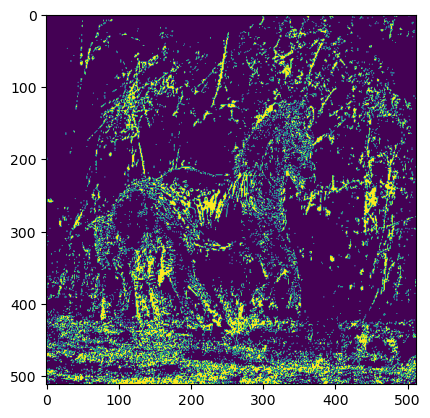

In [81]:
plt.imshow(mask.mean(-1).astype('uint8'))

## Conclusion

I hope this gives a good overview of how to tweak the `prompt_2_img` function to add additional capabilities to your stable diffusion loop. The understanding of this lower-level function is useful for trying your own idea to improve stable diffusion or implement new papers which I might cover in my next post.

I hope you enjoyed reading it, and feel free to use my code and try it out for generating your images. Also, if there is any feedback on the code or just the blog post, feel free to reach out on [LinkedIn](https://www.linkedin.com/in/aayushmnit/) or email me at aayushmnit@gmail.com.

[^1]: [DIFFEDIT: DIFFUSION-BASED SEMANTIC IMAGE EDITING WITH MASK GUIDANCE](https://arxiv.org/pdf/2210.11427.pdf)